In [153]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize

# from gensim.models.ldamulticore import LdaMulticore  # for big dataset, use multiple core machine
import gensim
from gensim.test.utils import common_texts
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

from nltk.corpus import stopwords
stops = stopwords.words("english")
import re

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis

/home/dianavo/.pyenv/versions/3.8.12/envs/nlp_project/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/dianavo/.pyenv/versions/3.8.12/envs/nlp_project/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


!pip install ipywidgets

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
from NLP_Natural_Disasters.data import get_data, clean_data

### exemple Semi-suppervised LDA sur Kaggle

https://www.kaggle.com/code/vanguarde/semi-supervised-lda

In [13]:
def text_cleaning(texts):
    texts_cleaning = []
    for txt in tqdm(texts):
        url = re.compile(r'https?://\S+|www\.\S+')
        html = re.compile(r'<.*?>')
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        txt = emoji_pattern.sub(r'', txt)
        txt = html.sub(r'',txt)
        txt = url.sub(r'',txt)
        txt = re.sub('[^A-Za-z\s]', '', txt)
        
        texts_cleaning.append(txt.lower())
    return texts_cleaning
text = text_cleaning(train_df.text.tolist())

  0%|          | 0/7613 [00:00<?, ?it/s]

In [14]:
from nltk.stem import PorterStemmer
text = [t.split() for t in text]
stemmed_text = []
ps = PorterStemmer()
for sentence in tqdm(text):
    sent = []
    for word in sentence:
        sent.append(ps.stem(word))
    stemmed_text.append(sent)

  0%|          | 0/7613 [00:00<?, ?it/s]

In [15]:
print(*stemmed_text[5][:20])
print(*text[5][:20])

rockyfir updat california hwi close in both direct due to lake counti fire cafir wildfir
rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires


In [16]:
dictionary = gensim.corpora.Dictionary(text_split)

IF doesn't work : dictionary.doc2bow  --> tqdm
tried solution :
conda install -c conda-forge ipywidgets
jupyter nbextension enable --py widgetsnbextension
SOLUTION : remove 'in tqdm' add a splitted list of sentences

In [17]:
stopword_ids = map(dictionary.token2id.get, stops)
dictionary.filter_tokens(bad_ids=stopword_ids)
dictionary.filter_extremes(no_below=20, no_above=0.7, keep_n=None)
dictionary.compactify() # remove gaps in id sequence
bow = [dictionary.doc2bow(line) for line in text_split]

In [18]:
disasters = ['disaster', 'bloodbath', 'collapse', 'crash', 'meltdown', 'doomsday', 'convulsion', 'accident', 'casualty', 'fatality', 
            'blast', 'catastrophe', 'traffic','hybrid', 'engine', 'license', 
            'tsunami', 'volcano','tornado','avalanche','earthquake','blizzard','drought','bushfire','tremor','magma','twister',
            'windstorm','cyclone','flood','fire','hailstorm','lava','lightning','hail','hurricane','seismic','erosion','whirlpool','whirlwind',
            'cloud','thunderstorm','barometer','gale','blackout','gust','force','volt','snowstorm','rainstorm','storm','nimbus','violent storm',
            'sandstorm','fatal','cumulonimbus','death','lost','destruction','money','tension','cataclysm','damage','uproot','underground',
            'destroy','arsonist','wind scale','arson','rescue','permafrost','fault','shelter', 'bomb', 'suicide', 'tragedy', 'weapon']

disasters = [ps.stem(word) for word in disasters]

# add more topics later on

In [19]:
seed_topics = {}
for word in disasters:
    seed_topics[word] = 0

In [20]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [21]:
eta = create_eta(seed_topics, dictionary, 2)

In [22]:
eta

array([[5.000000e-01, 5.000000e-01, 5.000000e-01, ..., 9.999999e-01,
        5.000000e-01, 5.000000e-01],
       [5.000000e-01, 5.000000e-01, 5.000000e-01, ..., 9.999999e-08,
        5.000000e-01, 5.000000e-01]])

For now, Number of topics = 2: disasters , common topic

In [23]:
# random_state=42
lda_model_core = LdaMulticore(corpus=bow, #bag of words
                         id2word=dictionary, #our common dict, need for print words in topics, not numbers from bow
                         num_topics=2,
                         eta=eta, #our eta matrix
                         chunksize=2000,
                         passes=10,
                         random_state=42,
                         alpha='symmetric', #param of LDA distribution. If you dont know use symmetric
                         per_word_topics=True)

In [24]:
for num, params in lda_model_core.print_topics():
    print(f'{num}: {params}\n')

0: 0.018*"fire" + 0.014*"u" + 0.013*"storm" + 0.013*"weapon" + 0.012*"amp" + 0.012*"video" + 0.011*"new" + 0.010*"bomb" + 0.009*"disaster" + 0.007*"siren"

1: 0.017*"like" + 0.015*"im" + 0.011*"suicide" + 0.011*"get" + 0.009*"one" + 0.009*"dont" + 0.008*"people" + 0.008*"police" + 0.008*"look" + 0.007*"news"



### LDA Topic Modelisation avec Gensim :  Creer des topics (pertinent!) , analyse mot -> classifier

In [99]:
## EDA cleaning process

data = get_data()
data_clean = clean_data(data)

#data_clean.head()

,id,text,target
0,1,deed reason earthquake may allah forgive u,1
1,4,forest fire near la canada,1
2,5,resident asked shelter place officer evacuation shelter place order expected,1
3,6,people receive wildfire evacuation order california,1
4,7,got sent photo alaska smoke wildfire school,1


In [100]:
X_train = data_clean['text']

# transform to a list, split to get list of each sentence splitted for gensim.corpora.Dict
list_tweet = X_train.tolist()
text_split = [x.split() for x in list_tweet]

dictionary = gensim.corpora.Dictionary(text_split)

In [101]:
# Transformation to create a Bag of Words .doc2bow for LdaModel later
stopword_ids = map(dictionary.token2id.get, stops)
dictionary.filter_tokens(bad_ids=stopword_ids)
dictionary.filter_extremes(no_below=20, no_above=0.7, keep_n=None)
dictionary.compactify() # remove gaps in id sequence
bow = [dictionary.doc2bow(line) for line in text_split]

### Topic analysis : Raw data

In [ ]:
target_1_raw = data[data['target']==1]
target_1_raw = target_1_raw['text'] 

In [ ]:
pd.DataFrame(target_1_raw)

### Gensim LDA model syntax tuto

https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel

In [ ]:
"""Train an LDA model using a Gensim corpus"""

# Create a corpus from a list of texts
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=10)


    """Save a model to disk, or reload a pre-trained model"""
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("model")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)


    """Query, the model using new, unseen documents"""
# Create a new corpus, made of previously unseen documents.
other_texts = [
    ['computer', 'time', 'graph'],
    ['survey', 'response', 'eps'],
    ['human', 'system', 'computer']
]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[0]
vector = lda[unseen_doc]  # get topic probability distribution for a document


    """Update the model by incrementally training on the new corpus"""
lda.update(other_corpus)
vector = lda[unseen_doc]


    """A lot of parameters can be tuned to optimize training for your specific case"""
lda = LdaModel(common_corpus, num_topics=50, alpha='auto', eval_every=5)  # learn asymmetric alpha from data

### Create my own topics

> countvectoriser most_commun : tableau avec le compte totalde chaque mot et son occurence 

In [83]:
# list to create my 3 topic, 3rd is random other subjects

# this list means need forces intervention or involved
forces_intervention = ['accident', 'officers', 'evacuation', 'shelter', 'wildfire', 'wildfires', 'smoke', 'fire', 'emergency', 'die', 'died' 'ablaze', 'burn', 'burned',
'crash', 'accident', 'traffic', 'damage', 'deadly', 'kill', 'killed', 'explosion', 'death', 'ambulance', 'drunk', 'crime', 'attack', 'attacked', 'victim', 'stabbed', 'stabbing', 'arson',
'arrested', 'arrestation', 'burning', 'arsonist', 'collided', 'collision', 'police', 'suicide', 'bombing', 'injured', 'terrorist', 'avalanche', 'army', 'derailed', 'stab', 'blew', 'collapse']

weather_phenomen = ['eruption', 'earthquake', 'catastrophic effect','heavy', 'rain', 'flood', 'tornado', 'heat', 'tsunami', 'volcano','tornado', 'magma', 'windstorm','cyclone','hailstorm','lava','hail','hurricane','seismic','erosion',
'whirlwind', 'cloud','thunderstorm','barometer','gale','blackout','gust','snowstorm','rainstorm','storm','nimbus','violent storm', 'sandstorm','cumulonimbus']

forces_intervention = [ps.stem(word) for word in forces_intervention]
weather_phenomen = [ps.stem(word) for word in weather_phenomen]

**Placé dans target1**
'star wars',  'Indeed!! I am fully aware of that battle! I support you in that fight!'

menace : 'you can stab me in the back but I promise you'll be the one bleeding'

news : 'transport bioterror germs in wake of anthrax'

suspect = ['afraid', 'hate', 'bomb']

In [84]:
# initialize value 0 to each word to go through,then we'll use create_eta() function to add a big value if word in lists above

seed_topics_forces = {}

for word in forces_intervention:
    seed_topics_forces[word] = 0
    
seed_topics_weather = {}

for word in weather_phenomen:
    seed_topics_weather[word] = 1

In [85]:
seed_topics_forces

{'accid': 0,
 'offic': 0,
 'evacu': 0,
 'shelter': 0,
 'wildfir': 0,
 'smoke': 0,
 'fire': 0,
 'emerg': 0,
 'die': 0,
 'diedablaz': 0,
 'burn': 0,
 'crash': 0,
 'traffic': 0,
 'damag': 0,
 'deadli': 0,
 'kill': 0,
 'explos': 0,
 'death': 0,
 'ambul': 0,
 'drunk': 0,
 'crime': 0,
 'attack': 0,
 'victim': 0,
 'stab': 0,
 'arson': 0,
 'arrest': 0,
 'arsonist': 0,
 'collid': 0,
 'collis': 0,
 'polic': 0,
 'suicid': 0,
 'bomb': 0,
 'injur': 0,
 'terrorist': 0,
 'avalanch': 0,
 'armi': 0,
 'derail': 0,
 'blew': 0,
 'collaps': 0}

> Custom eta parameter of gensim.models.ldamodel.LdaModel

In [102]:
def create_eta(dict_priors, etadict, ntopics):
    """ create 'eta' parameter in LdaModel,
    dict_priors  is a list of dicts from see_topics """
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    
    for dict_prior in dict_priors:
        
        for word, topic in dict_prior.items(): # for each word in the list of priors
            
            keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
            if (len(keyindex)>0): # if it's in the dictionary
                eta[topic,keyindex[0]] = 1e7  # put a large number in there
                
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [103]:
# create my own eta, affect a big value to a word in my seed_topics_force, seed_topic_weather
# IF is in my lists created above (force_intervention, weather_phenomen')
eta = create_eta([seed_topics_forces, seed_topics_weather], dictionary, 3)

Define LdModel() : gensim.models.ldamodel.LdaModel

### LDA model custom

class **gensim.models.ldamodel.LdaModel**(corpus=None, num_topics=100, id2word=None, distributed=False, chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, minimum_probability=0.01, random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None, dtype=<class 'numpy.float32'>)

**random_state** ({np.random.RandomState, int}, optional) – Either a randomState object or a seed to generate one. Useful for reproducibility.
random_state - this serves as a seed (in case you wanted to repeat exactly the training process)
**chunksize** - number of documents to consider at once (affects the memory consumption)

**update_every** - update the model every update_every chunksize chunks (essentially, this is for memory consumption optimization)

**passes** - how many times the algorithm is supposed to pass over the whole corpus

chunksize - number of documents to consider at once (affects the memory consumption)

In [158]:
num_topics=3
chunksize=2000
passes = 25
random_state = 100

In [159]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow, #bag of words
                         id2word=dictionary, #our common dict, need for print words in topics, not numbers from bow
                         num_topics=num_topics,
                         eta=eta, #our eta matrix
                         chunksize=chunksize,
                        update_every = 1,
                         passes=passes,
                         random_state=random_state,
                         alpha='asymmetric', #param of LDA distribution. If you dont know use symmetric
                        minimum_probability = 0.0,
                         per_word_topics=True)

# --> alpha='symmetric' SAME result, auto : diff results, 
# random_state : serves as a seed (in case you wanted to repeat exactly the training process)
# n_jobs = -1
# update_every = 1
# per_word_topics=True
# random_state=100,

In [142]:
# print 10 words and its percentage in each topics (0-2)
for num, params in lda_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.033*"fire" + 0.020*"news" + 0.017*"video" + 0.017*"via" + 0.015*"suicide" + 0.014*"california" + 0.013*"year" + 0.013*"home" + 0.013*"still" + 0.012*"look"

1: 0.026*"u" + 0.023*"amp" + 0.016*"disaster" + 0.015*"storm" + 0.015*"police" + 0.014*"family" + 0.013*"time" + 0.013*"pm" + 0.013*"wreck" + 0.011*"nuclear"

2: 0.030*"like" + 0.025*"im" + 0.019*"get" + 0.018*"weapon" + 0.017*"new" + 0.017*"one" + 0.015*"people" + 0.015*"dont" + 0.012*"day" + 0.010*"go"



**Premier essai : FAILED ! (code deleted)**

### Visualizing the entity recongnizer¶

In [30]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher

# 1. Loading the language library
nlp = spacy.load('en_core_web_sm')
text = u'''
Elon Musk, the billionaire CEO of Tesla and SpaceX, is now the richest person in the world, surpassing former titleholder and Amazon chief Jeff Bezos with a net worth of $189.7 billion, according to Forbes’s real-time billionaire net-worth estimates on Jan. 8, 2021 at 1pm.
2 - Since March, Musk’s wealth has grown almost seven-fold, up a staggering $163.1 billion.
'''
# 2. Building a Pipline Object
doc = nlp(text)


In [31]:
displacy.render(doc, style='dep', jupyter=True, options={'distance':90})

In [32]:
displacy.render(doc, style='ent', jupyter=True)

Autre plot fancy :

Extracting tf features for LDA...
done in 0.216s.



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 13.520s.


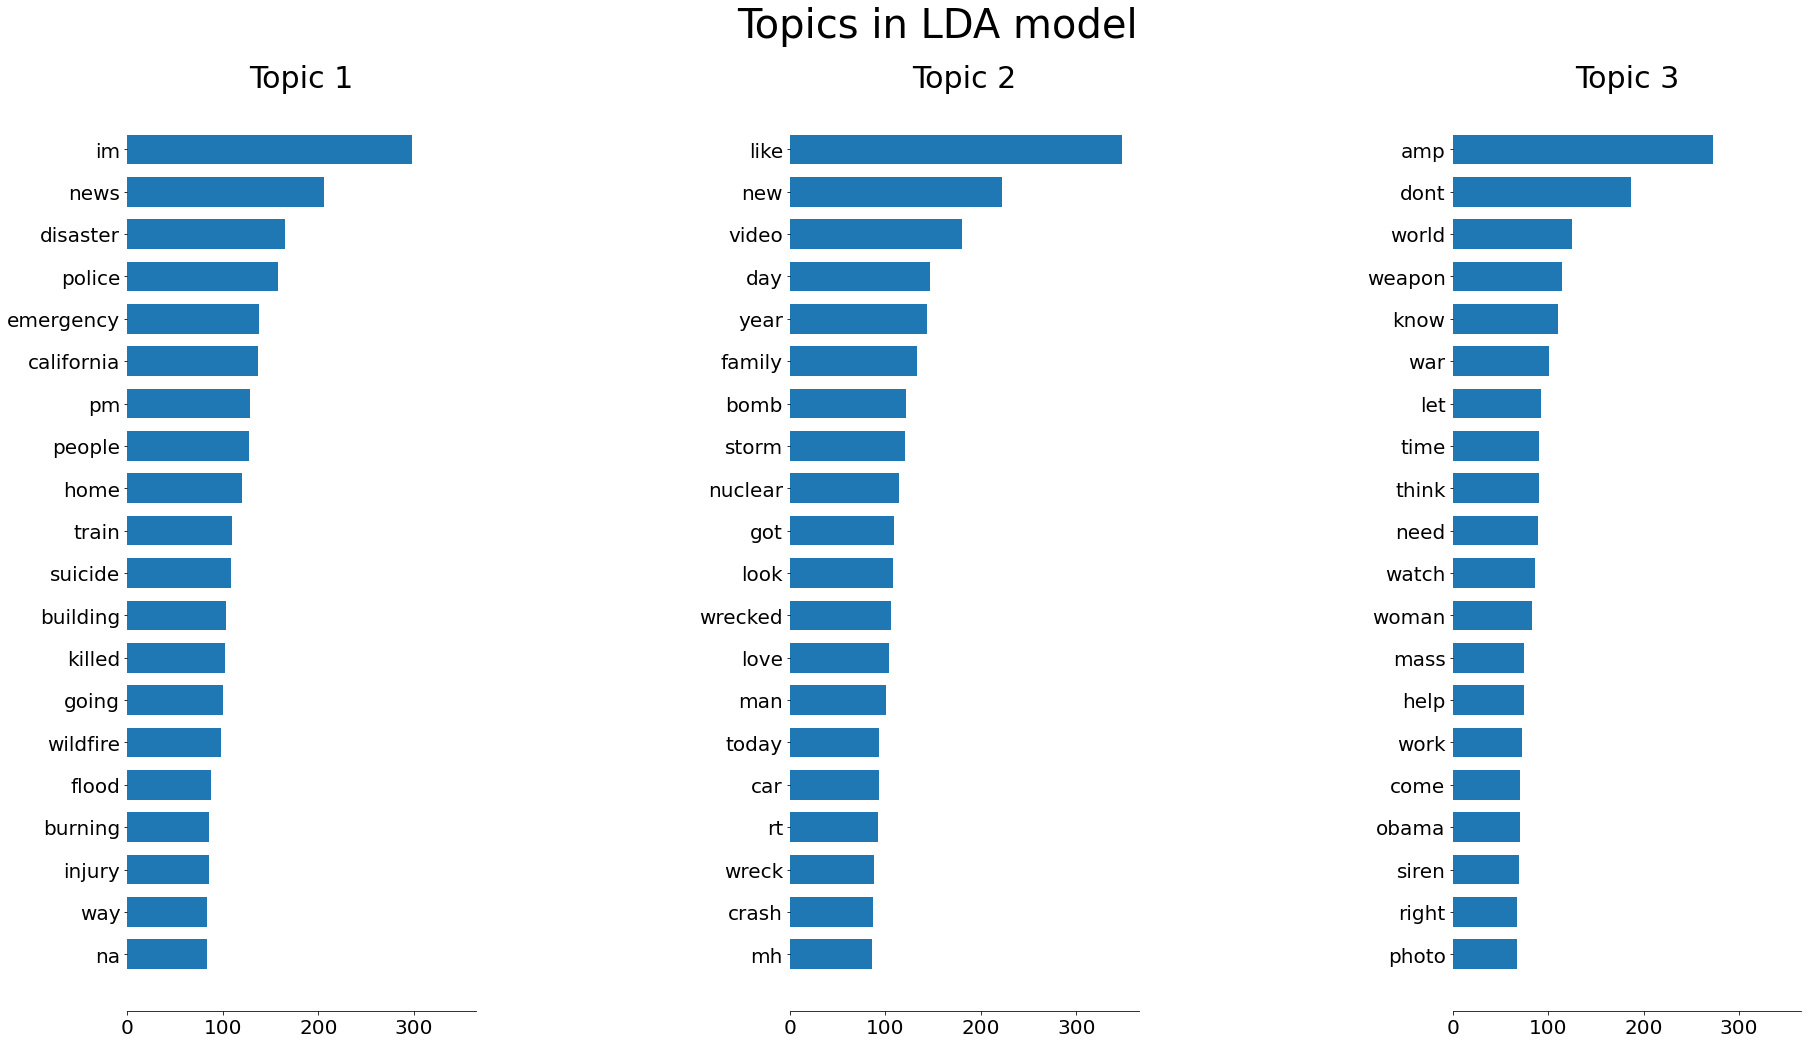

In [33]:

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 3
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

data_samples = list_tweet

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()


print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### Get_document_topics :    Exemple with an input test

"objectif : comprendre parfaitement gensim.ldamodel"

faire marcher la pred

afficher rps de chaque topic avec les methodes du model, conclusions, si topic utilise les bon mots ?

sinon, regler alpha pour la distribution des topics 

bien classer : countvectoriser pour determiner l'occurence des mot en pair, les mettre dans mes list de topics


> **get_document_topics** : Get the most relevant topics to the given word.

In [63]:
def countvecto(allsentences):
    """Vectorise sentences, transform to array"""
    vectorizer = CountVectorizer()
    # tokenize and build vocab    
    X = vectorizer.fit_transform(allsentences)
    return X.toarray()

def split_sentence(sentence):
    """split ONE sentence in individual words"""
    sentence_spl = [x.split() for x in sentence]
    return sentence_spl

def predict_topic(splitted_sentences):
    """Predict the corresponding topic with a list of sentences cleaned (stopwords) and splitted"""
    dictionary_pred = corpora.Dictionary(splitted_sentences)
    # dictionary.filter_extremes(no_below=20, no_above=0.7, keep_n=None)
    bow_pred = dictionary_pred.doc2bow(splitted_sentences)
    
    predict_topic = lda_model.get_document_topics(bow_pred)
    
    return predict_topic

> steps : lower, tokenize, doc2bow, get_document_topics

In [135]:
## INPUT an exemple as a list of ONE + CLEAN sentence ['man put fire school']
exemple = ['horrible accident man died in wings of airplane eruption earthquake catastrophic effect heavy rain flood']
# exemple = ['love fruit going work']

In [136]:
my_exemple_splitted = split_sentence(exemple)

In [137]:
my_exemple_splitted

[['horrible',
  'accident',
  'man',
  'died',
  'in',
  'wings',
  'of',
  'airplane',
  'eruption',
  'earthquake',
  'catastrophic',
  'effect',
  'heavy',
  'rain',
  'flood']]

In [138]:
# use the function countvecto() to vectorize the sentence
exemple_vecto = countvecto(my_exemple_splitted[0])

In [145]:
# predict the probability in each topic using predict_topic()
predict_topic(exemple_vecto)

[(0, 0.4766271), (1, 0.3021695), (2, 0.22120342)]

In [168]:
# print properly :
final_predic = predict_topic(exemple_vecto)

pourcentage = [element[1] for element in final_predic]
pourcentage

[0.4766271, 0.3021695, 0.22120342]

In [170]:
print(f"topic 1 : {pourcentage[0]} %")
print(f"topic 2 : {pourcentage[1]} %")
print(f"topic 3 : {pourcentage[2]} %")

topic 1 : 0.47699999809265137 %
topic 2 : 0.3021695017814636 %
topic 3 : 0.22120341658592224 %


In [174]:
# # To plot at Jupyter notebook
# pyLDAvis.enable_notebook()
# plot = pyLDAvis.prepare(lda_model, bow, dictionary, vocab=)
# # Save pyLDA plot as html file
# pyLDAvis.save_html(plot, 'LDA_NYT.html')
# plot

TypeError: prepare() missing 2 required positional arguments: 'vocab' and 'term_frequency'

> Coherence value : Choosing the Best Number of Topics

In [160]:
# def compute_coherence_values(dictionary, corpus, texts, 
#                              cohere, limit, start=2, step=2):
#     iterations = 100
#     temp = dictionary[0]
#     id2word = dictionary.id2token

#     coherence_values = []

#     for num_topics in range(start, limit, step):
#         model = LdaModel(corpus=corpus, 
#                          id2word=dictionary, 
#                          num_topics=num_topics,
#                          chunksize=chunksize,
#                          alpha='auto',
#                          eta='auto',
#                          iterations=iterations,
#                          passes=passes,
#                          eval_every=1,
#                          random_state=42,)
#         coherencemodel = CoherenceModel(model=model, 
#                                         texts=texts, 
#                                         dictionary=dictionary, 
#                                         coherence=cohere)
#         coherence_values.append(coherencemodel.get_coherence())

#     return coherence_values

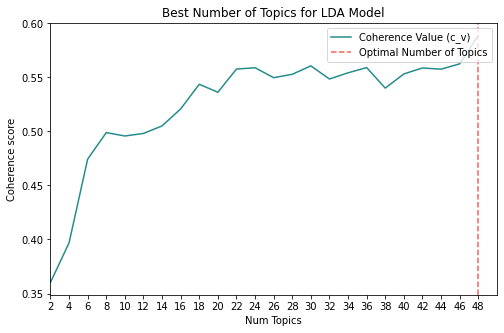

In [161]:
##### 30 min to run, in 8G RAM ####

# limit=50
# start=2
# step=2
# corpus = bow
# texts = text_split

# coherence_values = compute_coherence_values(dictionary=dictionary, 
#                                             corpus=corpus, 
#                                             texts=texts, 
#                                             cohere='c_v', 
#                                             start=start, 
#                                             limit=limit, 
#                                             step=step)

# plt.figure(figsize=(8,5))

# # Create a custom x-axis
# x = range(start, limit, step)

# # Build the line plot
# ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# # Set titles and labels
# plt.title("Best Number of Topics for LDA Model")
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.xlim(start, limit)
# plt.xticks(range(2, limit, step))

# # Add a vertical line to show the optimum number of topics
# plt.axvline(x[np.argmax(coherence_values)], 
#             color='#F26457', linestyle='--')

# # Draw a custom legend
# legend_elements = [Line2D([0], [0], color='#238C8C', 
#                           ls='-', label='Coherence Value (c_v)'),
#                    Line2D([0], [1], color='#F26457', 
#                           ls='--', label='Optimal Number of Topics')]

# ax.legend(handles=legend_elements, loc='upper right')

Display topics visually